In [1]:
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import multiprocessing as mp

import gymnasium as gym
from gymnasium import spaces
from dynamic_tasker.access import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.orbits import *
from dynamic_tasker.cameras import *
from dynamic_tasker.scenario import *
from tqdm import tqdm

%load_ext autoreload 
%autoreload 2

In [8]:
class LookaheadGenerator():
    def __init__(self, orbit, requests, t_start, t_end, agility, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=False):
        self.orbit = orbit
        self.requests = requests
        self.t_start = t_start
        self.t_end = t_end
        self.agility = agility
        self.field_of_regard = field_of_regard
        self.width = 800
        self.height = 800
        

        self.K = get_intrinsics_from_fov(45, self.width, self.height)
        self.eval_analytic = eval_analytic
        self.orbit_reset_count = 0
        # Obtain the omniscient schedule
        self.accesses = get_accesses(requests, orbit, 500, 45, t_start, t_end)
        # Assign the states
        for i in range(len(self.accesses)):
            self.accesses[i].state = {"observed": False, "cloudy": np.random.rand() < 0.66, "utility": np.random.pareto(1)}

        # self.optimal_schedule = milp_schedule(self.orbit, self.requests, t_start, t_end)
        self.schedule = milp_schedule(self.accesses, self.requests, self.agility)
        # Calculate how many tasks in the schedule are not cloudy
        self.base_advantage = np.sum([not a.state["cloudy"] for a in self.schedule])
        self.current_idx = 0
        
        # Try first discretizing in just time and angle...
        self.crosstrack_discretization = crosstrack_discretization
        self.alongtrack_discretization = alongtrack_discretization

        # Figure out the number of states
        self.crosstrack_states = int(np.floor(2 * self.field_of_regard / (self.crosstrack_discretization)))
        # First figure out the horizon angle
        self.horizon_angle = horizon_angle(self.orbit)
        self.horizon_time = horizon_time(self.orbit)
        self.alongtrack_states = int(np.floor(self.horizon_time/ (self.alongtrack_discretization)))
        # total_observational_states = crosstrack_states * alongtrack_states



    def step(self, action):
        # Current time...
        time = self.schedule[self.current_idx].time
        orbit_new = propagate_orbit(self.orbit, time)
        r , v = kepler2eci(orbit_new)
        pos_ecef = eci2ecef(r, time)

        # Convert to ECEF points
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(self.accesses)]
        accesses_filtered = filter_accesses_horizon(orbit_new, time, accesses_converted, pos_ecef, self.field_of_regard)
       
        # Randomly zero out all the observations
        zero_accesses = np.random.rand() < 0.0
        
        current_state = self._get_obs(self.accesses, self.schedule, time, zero_accesses)


        points = np.array([r for r, _, _, _, _ in accesses_filtered])

        # Get pitch and roll from action
        pitch_deg = action[0] * (np.rad2deg(self.horizon_angle))
        # roll_deg = np.arcsin(action[2])
        # For now roll_deg = 0
        roll_deg = action[1] * (self.field_of_regard)
        t_maneuver = (self.agility(pitch_deg - 22.5) - self.agility(0)) * 2
        missed_opportunities = len([s for s in self.schedule if s.time >= time and s.time <= time + datetime.timedelta(seconds=t_maneuver)])

        if(zero_accesses):
            if(self.current_idx < len(self.schedule) - 1):
                self.current_idx = self.current_idx + 1
            else:
                self.reset()
                
            return current_state, -missed_opportunities

        if(len(accesses_filtered) == 0):
            # Move to the next schedule block
            if(self.current_idx < len(self.schedule) - 1):
                self.current_idx = self.current_idx + 1
            else:
                self.reset()

            return current_state, 0
        
        # Now project them into the camera frame
        projected_accesses, in_box, projected_points = project_in_box(pitch_deg, roll_deg, orbit_new, time, accesses_filtered, points, self.width, self.height, self.K)

        # Mark the ones in box as observed
        for i in in_box:
            accesses_filtered[i][-2].state["observed"] = True

        # Calculate the total advantage
        times = [a[-2].time for a in projected_accesses]

        if(len(times) == 0):
            # Move to the next schedule block
            if(self.current_idx < len(self.schedule) - 1):
                self.current_idx = self.current_idx + 1
            else:
                self.reset()

            
            return current_state, -(missed_opportunities)

        max_time = np.max(times)
        min_time = np.min(times)

        # Get the slice of the schedule that is in the time range
        schedule_slice = [a for a in self.schedule if a.time >= min_time and a.time <= max_time]
        schedule_slice_idx = [i for i, a in enumerate(self.schedule) if a.time >= min_time and a.time <= max_time]

        original_schedule_advantage = np.sum([a.utility for a in schedule_slice if not a.state["cloudy"]])
        access_slice = [a for a in self.accesses if a.time >= min_time and a.time <= max_time and not (a.state["observed"] and a.state["cloudy"])]
        # access_slice = [a for a in self.accesses if a.time >= min_time and a.time <= max_time]
        # access_slice_omni = [a for a in self.accesses if a.time >= min_time and a.time<= max_time and not (a.state["cloudy"])]

        if(len(access_slice) == 0):
            if(self.current_idx < len(self.schedule) - 1):
                self.current_idx = self.current_idx + 1
            else:
                self.reset()

            return current_state, -missed_opportunities

        # todo: this is a hack to handle the case where the schedule slice is empty, see if we can fix this
        if(len(schedule_slice) == 0):
            schedule_slice_idx_start = self.current_idx + 1
            schedule_slice_idx_end = self.current_idx + 1

            if(self.current_idx < len(self.schedule) - 1):
                self.current_idx = self.current_idx + 1
            else:
                self.reset()

            return current_state, -missed_opportunities
        else:
            # Find the bounding accesses of the schedule within the observation window...
            schedule_slice_idx_start = np.min(schedule_slice_idx)
            schedule_slice_idx_end = np.max(schedule_slice_idx)
        
        force_start_in = True
        force_end_in = True

        force_in = []

        if(schedule_slice_idx_start == 0):
            force_start_in = False
        else:
            force_in.append(self.schedule[schedule_slice_idx_start - 1])

        if(schedule_slice_idx_end == len(self.schedule) - 1):
            force_end_in = False
        else:
            force_in.append(self.schedule[schedule_slice_idx_end + 1])

        if(force_start_in):
            access_slice.insert(0, self.schedule[schedule_slice_idx_start - 1])

        if(force_end_in):
            access_slice.append(self.schedule[schedule_slice_idx_end + 1])

        new_schedule_slice = milp_schedule(access_slice, self.requests, self.agility, force_in)
        # Cut out the forced in accesses
        new_schedule_slice = new_schedule_slice[1:-1]

        # omni_schedule = milp_schedule(access_slice_omni, self.requests, self.agility)

        new_advantage = np.sum([a.utility for a in new_schedule_slice if not a.state["cloudy"]])
        # omni_advantage = len(omni_schedule)

        # 22.5 deg boresight        
        t_maneuver = (self.agility(pitch_deg - 22.5) - self.agility(0)) * 2
        missed_opportunities = np.sum([s.utility for s in schedule_slice if not s.state["cloudy"] and self.agility(s.angle) > t_maneuver])
        
        # Assign the schedule to the current schedule
        self.schedule = self.schedule[:schedule_slice_idx_start] + new_schedule_slice + self.schedule[schedule_slice_idx_end + 1:]

        # Move to the next schedule block
        if(self.current_idx < len(self.schedule) - 1):
            self.current_idx = self.current_idx + 1
        else:
            self.reset()

        return current_state, (new_advantage - original_schedule_advantage - missed_opportunities)
        
    
    def reset(self, seed=None, options=None):
        # Only actually reset when current_idx is at the end
        if self.current_idx >= (len(self.schedule) - 1):
            self.orbit_reset_count = self.orbit_reset_count + 1

            if(self.orbit_reset_count > 10):
                self.requests = generate_requests(10000)
                self.accesses = get_accesses(self.requests, self.orbit, 500, 45, self.t_start, self.t_end)
                self.orbit_reset_count = 0

            self.current_idx = 0
            for a in self.accesses:
                a.state = {
                    "observed": False,
                    "cloudy": np.random.rand() < 0.66,
                    "utility": np.random.pareto(1)
                }
                
            self.schedule = milp_schedule(self.accesses, self.requests, self.agility)
            
        r , v = kepler2eci(self.orbit)
        pos_ecef = eci2ecef(r, self.t_start)    
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(self.accesses)]
        accesses_filtered = filter_accesses_horizon(self.orbit, self.t_start, accesses_converted, pos_ecef)

    def _get_obs(self, accesses, schedule, time, zero_accesses=False):
        # Source data
        times = [(a.time - time).total_seconds() for a in accesses if not a.state["observed"]]
        angles = [a.angle for a in accesses if not a.state["observed"]]
        weights = [a.utility for a in accesses if not a.state["observed"]]

        schedule_times = [(a.time - time).total_seconds() for a in schedule]
        schedule_angles = [a.angle for a in schedule]
        schedule_weights = [a.utility for a in schedule]

        # Convert to 2D histogram
        hist_accesses = np.histogram2d(times, angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]])
        hist_schedule = np.histogram2d(schedule_times, schedule_angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]])

        hist_accesses_weights = np.histogram2d(times, angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]], weights=weights)
        hist_schedule_weights = np.histogram2d(schedule_times, schedule_angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]], weights=schedule_weights)

        if(zero_accesses):
            return np.stack([np.zeros_like(hist_accesses[0]).astype(np.float32), hist_schedule[0].astype(np.float32), np.zeros_like(hist_accesses_weights[0]).astype(np.float32), hist_schedule_weights[0].astype(np.float32)])

        return np.stack([hist_accesses[0].astype(np.float32), hist_schedule[0].astype(np.float32), hist_accesses_weights[0].astype(np.float32), hist_schedule_weights[0].astype(np.float32)])

    def _get_reward(self):
        pass

    def close(self):    
        pass# Test the environment

In [358]:
# print(pairs)

In [9]:
t0 = datetime.datetime(2024, 1, 1)
t_end = datetime.datetime(2024, 1, 1, 12, 0, 0)

h = 400
field_of_regard = 45
crosstrack_discretization = 5 # deg
alongtrack_discretization = 5 # seconds

orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
requests = generate_requests(10000)

t_s = 10
t_dotsq = 4
def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))
    
env = LookaheadGenerator(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=False)
# env.reset()


/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T


In [10]:
for i in tqdm(range(10000)):
    a = env.step(np.array([np.random.rand(), 0]))

print(env.current_idx)

plt.imshow(a[0][0], cmap='turbo', origin='lower')
plt.show()

plt.imshow(a[0][1], cmap='turbo', origin='lower')
plt.show()

  4%|▍         | 420/10000 [00:08<03:17, 48.53it/s]


KeyboardInterrupt: 

In [7]:
env.step(np.array([0.5, 0]))

Warning: SCIPgetSolVal can only be called with a valid solution or in stage SOLVING (current stage: 10)

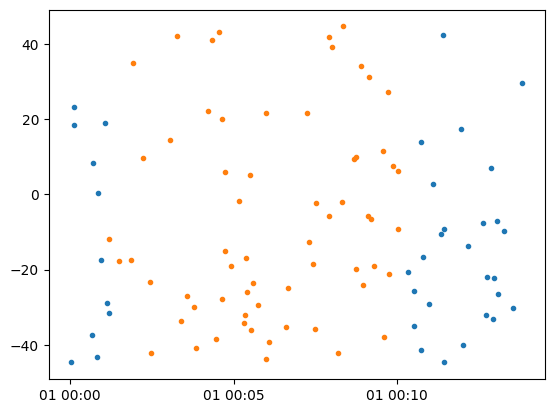

In [290]:
accesses = env.accesses[0:100]

plt.plot([a.time for a in accesses if not a.state["observed"]], [a.angle for a in accesses if not a.state["observed"]], '.')
plt.plot([a.time for a in accesses if a.state["observed"]], [a.angle for a in accesses if a.state["observed"]], '.')
plt.show()

In [27]:
# pairs = []
# for i in (range(1000)):
#     action = np.array([np.random.rand(), np.random.rand() * 2 - 1])
#     state, rew = env.step(action)
#     pairs.append((state, action, rew))

N_ENVS = 12
NUM_SAMPLES = 100000

def collect_data(seed):
    env = LookaheadGenerator(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=False)
    np.random.seed(seed)
    # state = env.reset()
    data = []

    for _ in tqdm(range(NUM_SAMPLES)):
        action = np.array([np.random.rand(), 0])
        state, rew = env.step(action)
        data.append((state, action, rew))

    return data

ctx = mp.get_context('fork')
with ctx.Pool(N_ENVS) as pool:
    results = pool.map(collect_data, range(N_ENVS))

pairs = [pair for sub in results for pair in sub]

/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: Runt

In [40]:
print(len(pairs))

1200000


In [28]:
# Save the pairs to a file
torch.save(pairs, "pairs_1200k.pt")

In [29]:
class StateActionDataset(Dataset):
    def __init__(self, triples):
        self.states  = torch.from_numpy(np.stack([t[0] for t in triples])).to(torch.float32)  # (N, C, H, W)
        self.actions = torch.from_numpy(np.stack([t[1] for t in triples])).to(torch.float32)  # (N, 2)
        self.rewards = torch.from_numpy(np.array([t[2] for t in triples])).unsqueeze(1).to(torch.float32)  # (N, 1)

    def __len__(self):              return len(self.rewards)
    def __getitem__(self, idx):     return self.states[idx], self.actions[idx], self.rewards[idx]

full_dataset = StateActionDataset(pairs)
train_size   = int(0.8 * len(full_dataset))
test_size    = len(full_dataset) - train_size
train_ds, test_ds = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, pin_memory=True)

In [ ]:
class ConvMLPReward(nn.Module):
    def __init__(self, state_shape, mlp_hidden=128, attn_heads=2):
        super().__init__()
        C, H, W = state_shape
        self.conv = nn.Sequential(
            nn.Conv2d(C, 8, kernel_size=7, padding=3), nn.LeakyReLU(), nn.BatchNorm2d(8),
            # nn.Conv2d(8, 16, kernel_size=7, padding=3), nn.LeakyReLU(), nn.BatchNorm2d(16),
        )

        with torch.no_grad():
            self.flat_dim = self.conv(torch.zeros(1, *state_shape)).numel()

        self.mlp = nn.Sequential(
            nn.Linear(self.flat_dim + 2, mlp_hidden), nn.LeakyReLU(),
            nn.Linear(mlp_hidden, mlp_hidden), nn.LeakyReLU(),
            nn.Linear(mlp_hidden, mlp_hidden), nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_hidden, mlp_hidden), nn.LeakyReLU(),
            nn.Linear(mlp_hidden, mlp_hidden), nn.LeakyReLU(),
            nn.Linear(mlp_hidden, 1)
        )

    def forward(self, state, action):
        x = self.conv(state)
        x = x.flatten(1)
        x = torch.cat([x, action], dim=1)
        return self.mlp(x)


device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model  = ConvMLPReward(train_ds.dataset.states.shape[1:]).to(device)

# -------------------------------------------
# 4. Training + TensorBoard
# -------------------------------------------
writer = SummaryWriter()
writer.add_graph(model,
                 (torch.zeros(1, *train_ds.dataset.states.shape[1:], device=device),
                  torch.zeros(1, 2, device=device)))

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-4)
loss_fn   = nn.L1Loss()
EPOCHS    = 100

for epoch in range(1, EPOCHS+1):
    # ---- TRAIN ----
    model.train()
    train_loss_accum = 0.0
    for states, actions, rewards in train_loader:
        states, actions, rewards = states.to(device), actions.to(device), rewards.to(device)
        preds = model(states, actions)
        loss  = loss_fn(preds, rewards)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_accum += loss.item() * states.size(0)

    avg_train_loss = train_loss_accum / train_size
    writer.add_scalar("Loss/train", avg_train_loss, epoch)

    # ---- TEST ----
    model.eval()
    test_loss_accum = 0.0
    with torch.no_grad():
        for states, actions, rewards in test_loader:
            states, actions, rewards = states.to(device), actions.to(device), rewards.to(device)
            preds = model(states, actions)
            test_loss_accum += loss_fn(preds, rewards).item() * states.size(0)

    avg_test_loss = test_loss_accum / test_size
    writer.add_scalar("Loss/test", avg_test_loss, epoch)

    print(f"Epoch {epoch:02d} — Train MSE: {avg_train_loss:.6f} — Test MSE: {avg_test_loss:.6f}")

    # ---- Optional: log histograms every 5 epochs ----
    if epoch % 5 == 0:
        for name, param in model.named_parameters():
            writer.add_histogram(name, param, epoch)

writer.close()
torch.save(model.state_dict(), "reward_model.pt")
print("✅ Done — model + logs saved.")

Epoch 01 — Train MSE: 0.856442 — Test MSE: 0.785452
Epoch 02 — Train MSE: 0.636507 — Test MSE: 0.493880
Epoch 03 — Train MSE: 0.458867 — Test MSE: 0.432568
Epoch 04 — Train MSE: 0.417967 — Test MSE: 0.405825
Epoch 05 — Train MSE: 0.396202 — Test MSE: 0.390815
Epoch 06 — Train MSE: 0.382113 — Test MSE: 0.385256
Epoch 07 — Train MSE: 0.370991 — Test MSE: 0.378286
Epoch 08 — Train MSE: 0.360776 — Test MSE: 0.378732
Epoch 09 — Train MSE: 0.351076 — Test MSE: 0.376397
Epoch 10 — Train MSE: 0.341924 — Test MSE: 0.375904


KeyboardInterrupt: 

In [42]:
torch.save(model.state_dict(), "reward_model_10_epochs.pt")


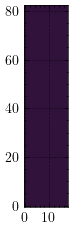

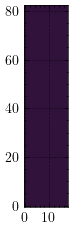

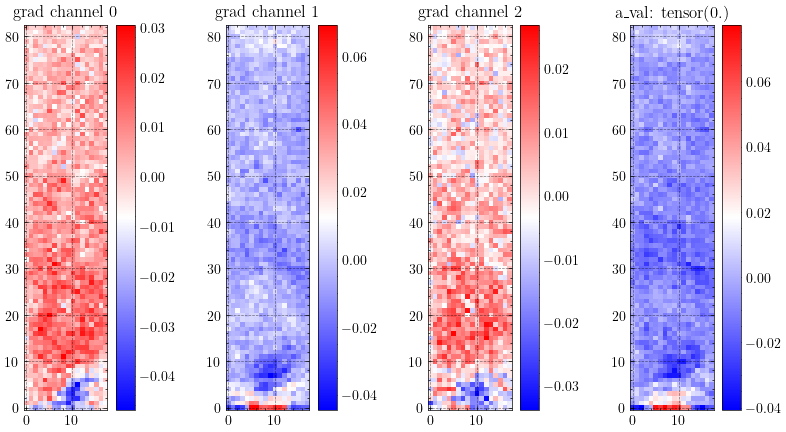

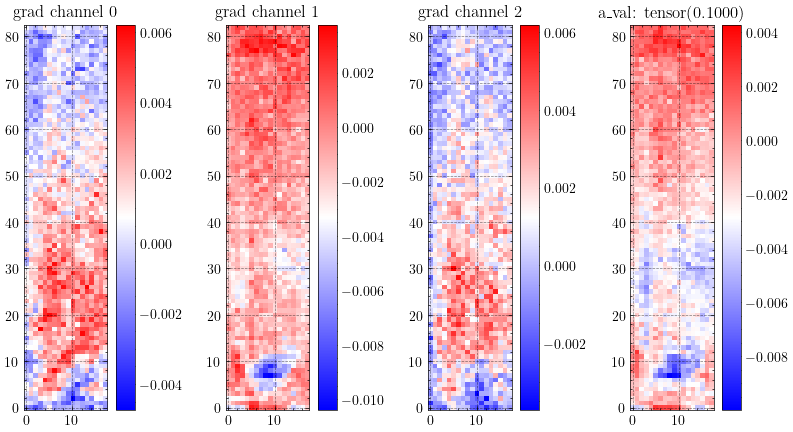

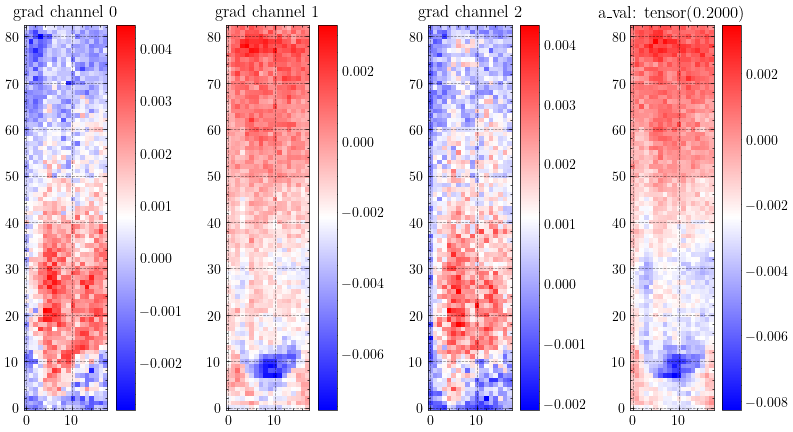

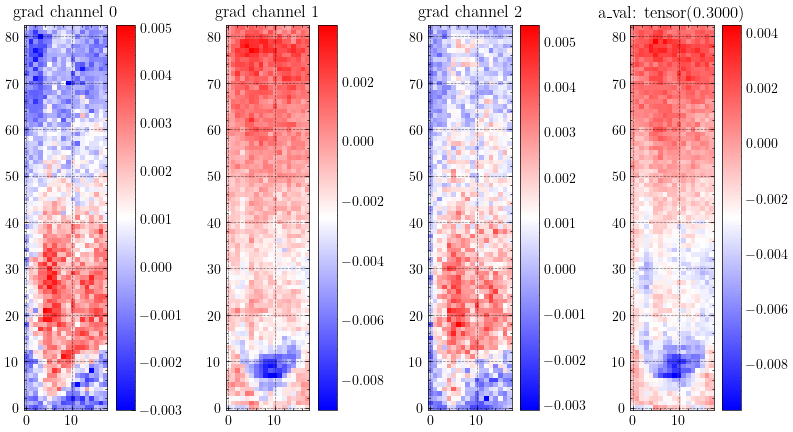

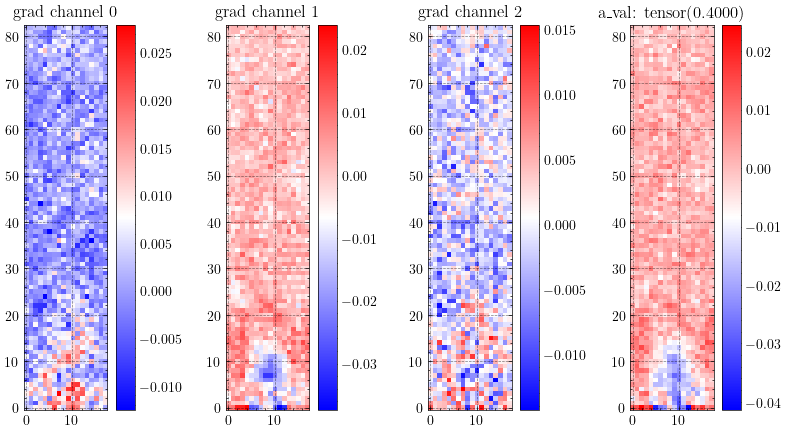

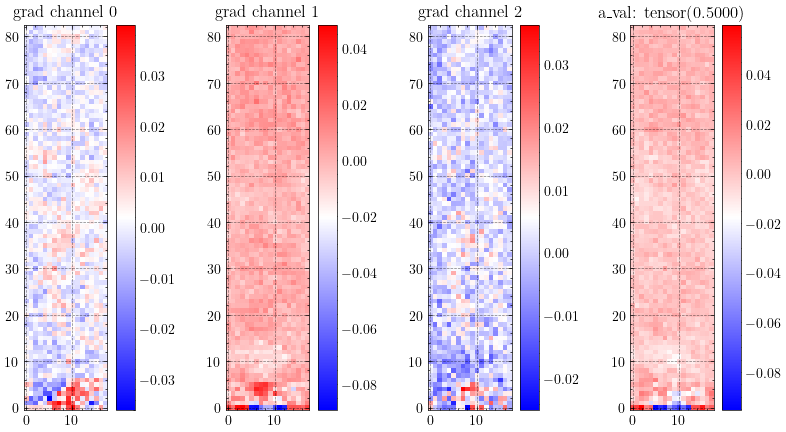

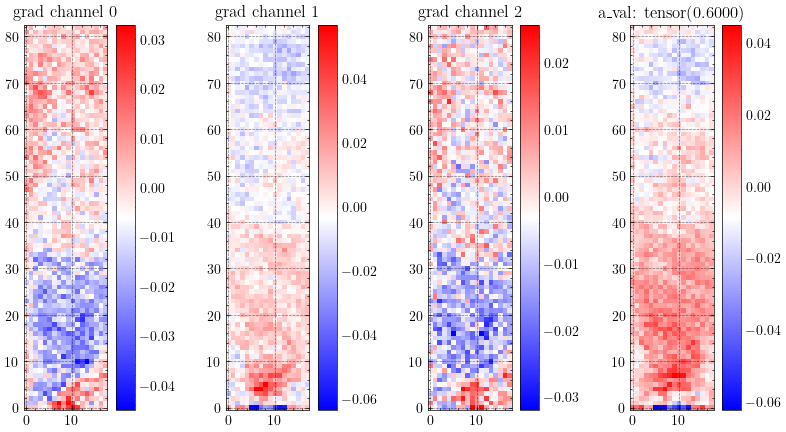

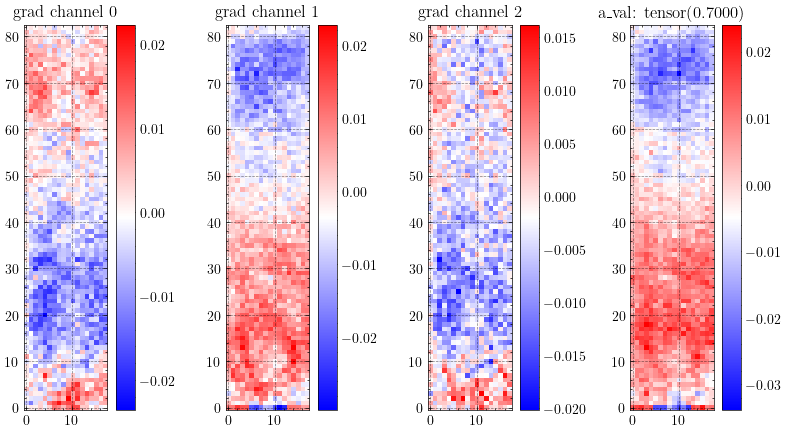

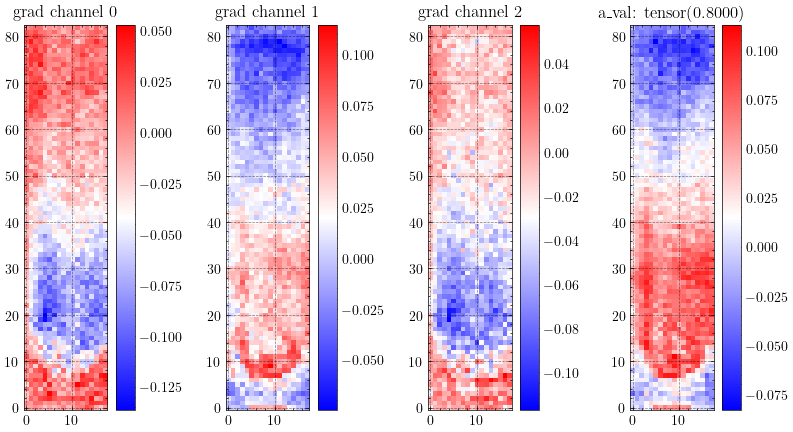

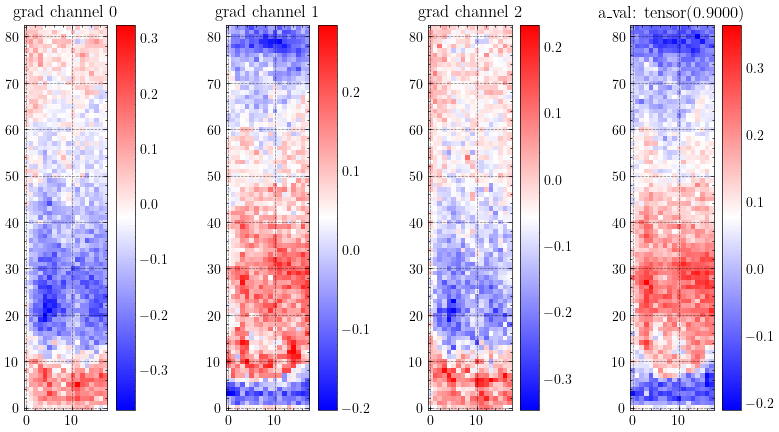

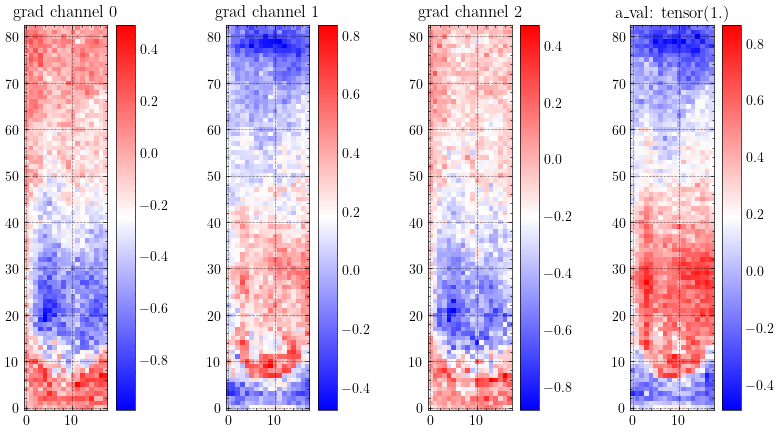

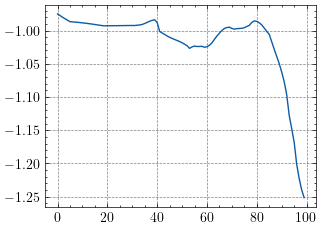

In [43]:
model.eval()                                # Freeze BN/Dropout if any

# base_state = full_dataset[0]

base_state_ch = torch.zeros_like(full_dataset[0][0]).to(device)
# base_state_ch = base_state[0].to(device)  # (C,H,W)
base_state_ch = base_state_ch.unsqueeze(0)        # (1,C,H,W)

# print(base_state[1], base_state[2])

plt.imshow(base_state_ch[0].cpu().numpy()[0], cmap='turbo', origin='lower')
plt.show()
plt.imshow(base_state_ch[0].cpu().numpy()[1], cmap='turbo', origin='lower')
plt.show()

for a_val in torch.linspace(0, 1, steps=11):
    action = torch.tensor([[a_val, 0.0]], device=device)   # (1,2)

    # 1) fresh leaf tensor each time
    state = base_state_ch.clone().detach().requires_grad_(True)

    # 2) forward
    out = model(state, action)              # shape (1,1)

    # 3) backward w.r.t. *state only*
    grad, = torch.autograd.grad(out, state) # same as state.grad

    # 4) visualize
    grad_np = grad.squeeze(0).cpu().numpy() # (C,H,W)

    # 5) Visualize per-channel (here we assume C=2, but you can loop)
    fig, axes = plt.subplots(1, grad_np.shape[0], figsize=(10,5))
    for i in range(grad_np.shape[0]):
        im = axes[i].imshow(grad_np[i], cmap='bwr', origin='lower')
        axes[i].set_title(f'grad channel {i}')
        plt.title("a_val: " + str(a_val))
        plt.colorbar(im, ax=axes[i])
    plt.show()

out_vals = []
actions = torch.linspace(0, 1, 100)
for a_val in actions:
    action = torch.tensor([[a_val, 0.0]], device=device)   # (1,2)

    # 1) fresh leaf tensor each time
    state = base_state_ch.clone().detach().requires_grad_(True)

    # 2) forward
    out = model(state, action)              # shape (1,1)
    out_vals.append(out.detach().cpu().numpy()[0][0])

plt.plot(out_vals)
plt.show()

tensor(True)


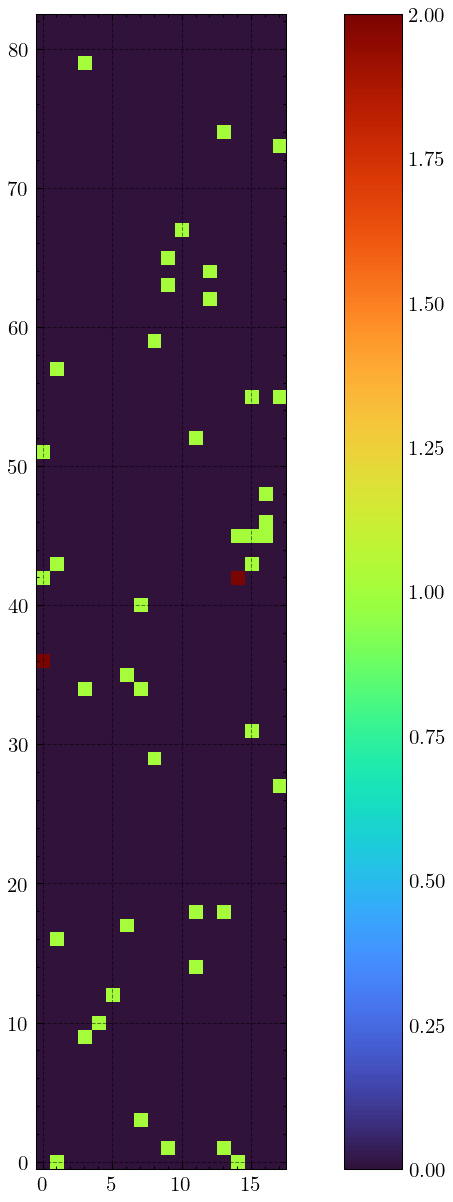

torch.Size([4, 83, 18]) torch.Size([2]) torch.Size([1])


In [343]:
import matplotlib.pyplot as plt

for i in range(100000):   
    state, action, reward = full_dataset[i]
    if(x:= torch.sum(state[0]) != 0):
        print(x)
        break

plt.figure(figsize=(10, 10), dpi=150)
plt.imshow(state[0], cmap='turbo', origin='lower')
plt.colorbar()
plt.show()

print(state.shape, action.shape, reward.shape)

torch.Size([2])


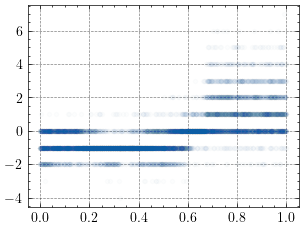

In [352]:
N = 10000

print(full_dataset[0][1].shape)

plt.plot([x[0] for x in full_dataset[0:N][1]], full_dataset[0:N][2], '.', alpha=0.01)
plt.show()

In [ ]:
# Histogram the advantage

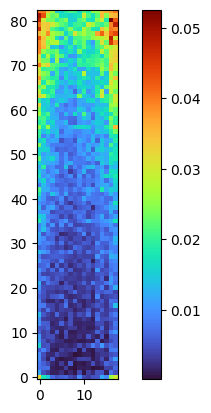

In [316]:
plt.imshow(torch.mean(full_dataset[0:100000][0], dim=0)[0], cmap='turbo', origin='lower')
plt.colorbar()
plt.show()

In [44]:
model.eval()                                # Freeze BN/Dropout if any

all_actions = []

for i in tqdm(range(1000)):
    # base_state = torch.zeros_like(full_dataset[i][0]).to(device)
    base_state = full_dataset[i][0].to(device)
    # full_dataset[0][0].to(device)  # (C,H,W)
    base_state = base_state.unsqueeze(0)        # (1,C,H,W)

    out_vals = []
    actions = torch.linspace(0, 1, 100)
    for a_val in actions:
        action = torch.tensor([[a_val, 0.0]], device=device)   # (1,2)

        # 1) fresh leaf tensor each time
        state = base_state.clone()

        # 2) forward
        out = model(state, action)              # shape (1,1)
        out_vals.append(out.detach().cpu().numpy()[0][0])

    all_actions.append(np.array(out_vals))


    

100%|██████████| 1000/1000 [01:12<00:00, 13.76it/s]


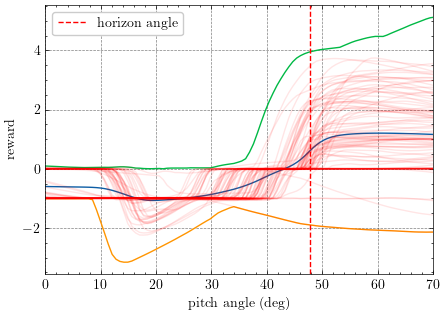

In [46]:
import scienceplots
plt.style.use(['science', 'grid'])

plt.figure(figsize=(5, 3.5))

plt.plot(np.linspace(0, np.rad2deg(horizon_angle(orbit)), 100),np.mean(all_actions, axis=0))
plt.plot(np.linspace(0, np.rad2deg(horizon_angle(orbit)), 100),np.max(all_actions, axis=0))
plt.plot(np.linspace(0, np.rad2deg(horizon_angle(orbit)), 100),np.min(all_actions, axis=0))

for i in range(100):
    plt.plot(np.linspace(0, np.rad2deg(horizon_angle(orbit)), 100),all_actions[i], alpha=0.1, color='r')

plt.axvline(x=np.rad2deg(horizon_angle(orbit))-22.5, color='red', linestyle='--', label="horizon angle")
plt.xlabel("pitch angle (deg)")
plt.ylabel("reward")
plt.legend()
plt.xlim(0, 70)
plt.show()